In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.random as npr
import scipy.special as sp

from dirichlet_paper import *

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec

import seaborn as sns
color_names = ["windows blue",
               "red",
               "gold",
               "grass green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")

In [2]:
test = False
# 100 -> seed 0
# 200 -> seed 103
npr.seed(0)
# Generate toy data
K = 100
N = 100
alpha0scalar = 1.0
alpha0 = alpha0scalar*np.ones(K)
p_true = npr.dirichlet(alpha0)
x = npr.multinomial(N,p_true)

assert np.sum(x) > 0, "Trivial dataset, try larger alpha0."

alpha_star = alpha0 + x
print(alpha_star[0])
if K < 0:
    print(alpha_star,x)

2.0


In [3]:
test = False

def true_gradient(alpha,alpha0,x):
    """
    Calculates the true gradient of the ELBO.
    """
    K = alpha.shape[0]
    N = np.sum(x)
    gradient = np.zeros(K)
    asum = np.sum(alpha)
    aXsum = alpha0-1.+x
    gradient = aXsum*sp.polygamma(1,alpha)-sp.polygamma(1,asum)*(N-K+np.sum(alpha0))
    return gradient + grad_entropy(alpha)

# Test
assert np.linalg.norm(true_gradient(alpha_star,alpha0,x)) < 1e-6, "Gradient not zero at optimum."

# Test
if test:
    print(scoreEstimator(alpha_star,alpha0,x,S=1000))
    T = 1000
    average_reparam = np.zeros(K)
    for i in range(T):
        average_reparam += reparam_gradient(alpha_star,alpha0,x,corr=False,B=30)/T
    print(average_reparam)

def Tfun(eps,alpha):
    return np.exp(np.sqrt(sp.polygamma(1,alpha))*eps+sp.digamma(alpha))

def Tinv(z,alpha):
    return (np.log(z)-sp.digamma(alpha))/np.sqrt(sp.polygamma(1,alpha))

def h_gen(eps,alpha):
    polyalpha = sp.polygamma(1,alpha)
    return Tfun(eps,alpha)*(0.5*eps*sp.polygamma(2,alpha)/np.sqrt(polyalpha)+polyalpha)

def u_gen(eps,alpha):
    polyalpha1 = sp.polygamma(1,alpha)
    polyalpha2 = sp.polygamma(2,alpha)
    return 0.5*eps*polyalpha2/np.sqrt(polyalpha1) +polyalpha1+ 0.5*polyalpha2/polyalpha1

def grad_logp_gen(z,alpha0,x):
    zsum = np.sum(z)
    asumx = np.sum(alpha0+x-1.)
    return (alpha0-1.+x)/z - asumx/zsum

def gen_reparam(alpha,alpha0,x):
    sample = npr.gamma(alpha,1.)
    Tinv_val = Tinv(sample,alpha)
    rep_grad = grad_logp_gen(sample,alpha0,x)*h_gen(Tinv_val,alpha)
    dlogQ_dz = (alpha-1.)/sample - 1.
    dlogQ_da = np.log(sample)-sp.digamma(alpha)
    corr_grad = logp(sample/np.sum(sample),alpha0,x)*(h_gen(Tinv_val,alpha)*dlogQ_dz +dlogQ_da + u_gen(Tinv_val,alpha))
    return corr_grad+rep_grad + grad_entropy(alpha)

# Test
if test:
    T = 100
    average_reparam = np.zeros(K)
    average_gen_reparam = np.zeros(K)
    for i in range(T):
        average_reparam += reparam_gradient(alpha_star,alpha0,x,corr=False,B=1)/T
        average_gen_reparam += gen_reparam(alpha_star,alpha0,x)/T
    print(average_reparam)
    print(average_gen_reparam)

In [4]:
# Estimate gradients
alpha_max = 2 * np.ceil(alpha_star[0])
alphas = np.linspace(1.01, 3.0, 100)#alpha_max, 100)
alpha = np.zeros(alpha_star.shape[0])
alpha[1:] = alpha_star[1:]
N_indep = 100

grad_true = np.zeros((alphas.shape[0],K))
grad_gen = np.zeros((alphas.shape[0],N_indep,K))
err_grad_gen = np.zeros((alphas.shape[0],N_indep,K))
grad_r_b0 = np.zeros((alphas.shape[0],N_indep,K))
err_grad_r_b0 = np.zeros((alphas.shape[0],N_indep,K))
grad_r_b1 = np.zeros((alphas.shape[0],N_indep,K))
err_grad_r_b1 = np.zeros((alphas.shape[0],N_indep,K))
grad_r_b3 = np.zeros((alphas.shape[0],N_indep,K))
err_grad_r_b3 = np.zeros((alphas.shape[0],N_indep,K))
grad_r_b100 = np.zeros((alphas.shape[0],N_indep,K))
err_grad_r_b100 = np.zeros((alphas.shape[0],N_indep,K))

for j in range(alphas.shape[0]):
    alpha[0] = alphas[j]
    grad_true[j,:] = true_gradient(alpha,alpha0,x)
    
    for i in range(N_indep):
        grad_gen[j,i,:] = gen_reparam(alpha,alpha0,x)
        err_grad_gen[j,i,:] = grad_gen[j,i,:]-grad_true[j,:]
        
        grad_r_b0[j,i,:] = reparam_gradient(alpha,alpha0,x,corr=True,B=0)
        err_grad_r_b0[j,i,:] = grad_r_b0[j,i,:]-grad_true[j,:]
        
        grad_r_b1[j,i,:] = reparam_gradient(alpha,alpha0,x,corr=True,B=1)
        err_grad_r_b1[j,i,:] = grad_r_b1[j,i,:]-grad_true[j,:]
        
        grad_r_b3[j,i,:] = reparam_gradient(alpha,alpha0,x,corr=True,B=3)
        err_grad_r_b3[j,i,:] = grad_r_b3[j,i,:]-grad_true[j,:]
        
        grad_r_b100[j,i,:] = reparam_gradient(alpha,alpha0,x,corr=True,B=10)
        err_grad_r_b100[j,i,:] = grad_r_b100[j,i,:]-grad_true[j,:]

In [5]:
import sys, os
sys.path.insert(0, os.path.abspath('../..'))
from neural_inverse_cdf_tests import gamma_variance_test
base_dir = os.path.join(os.getcwd(), '..', '..')
print(base_dir)

/home/andrew/PycharmProjects/neural-inverse-cdf-sampling/ars-reparameterization/dirichlet/../..


In [6]:
grad_nics = gamma_variance_test(x=x, alphas=alphas, alpha_prior=alpha0, N_trials=N_indep, base_dir=base_dir)

alpha max = 6.00
INFO:tensorflow:Restoring parameters from /home/andrew/PycharmProjects/neural-inverse-cdf-sampling/ars-reparameterization/dirichlet/../../InverseCDF/Gamma/checkpoint/gamma
Alphas done: 100.00%, Trials done: 100.00%


In [7]:
err_grad_nics = grad_nics - grad_true

In [8]:
folder = './'
filename = folder+'gen.npy'
np.save(filename,err_grad_gen)
filename = folder+'r1.npy'
np.save(filename,err_grad_r_b0)
filename = folder+'r2.npy'
np.save(filename,err_grad_r_b1)
filename = folder+'r3.npy'
np.save(filename,err_grad_r_b3)
filename = folder+'r4.npy'
np.save(filename,err_grad_r_b100)
filename = folder+'nics.npy'
np.save(filename,err_grad_nics)

In [9]:
folder = './'
filename = folder+'gen.npy'
err_grad_gen = np.load(filename)
filename = folder+'r1.npy'
err_grad_r_b0 = np.load(filename)
filename = folder+'r2.npy'
err_grad_r_b1 = np.load(filename)
filename = folder+'r3.npy'
err_grad_r_b3 = np.load(filename)
filename = folder+'r4.npy'
err_grad_r_b100 = np.load(filename)
filename = folder+'nics.npy'
err_grad_nics = np.load(filename)

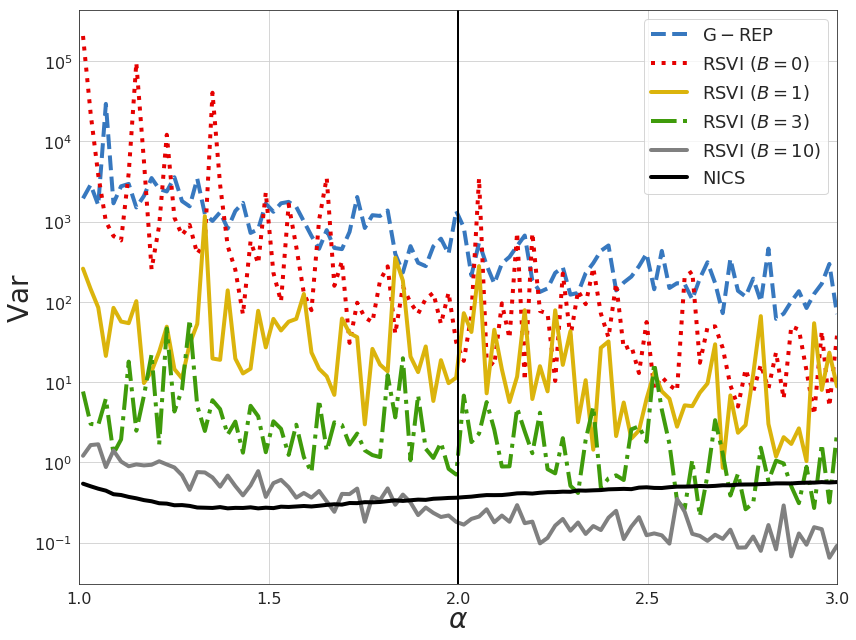

In [10]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)
ax.semilogy(alphas, np.mean(err_grad_gen**2,axis=1)[:,0], '--', color=colors[0], lw=4, label='$\\operatorname{G-REP}$')
ax.semilogy(alphas, np.mean(err_grad_r_b0**2,axis=1)[:,0], ':', color=colors[1], lw=4, label='$\\mathrm{RSVI}$ $(B=0)$')
ax.semilogy(alphas, np.mean(err_grad_r_b1**2,axis=1)[:,0], '-', color=colors[2], lw=4, label='$\\mathrm{RSVI}$ $(B=1)$')
ax.semilogy(alphas, np.mean(err_grad_r_b3**2,axis=1)[:,0], '-.', color=colors[3], lw=4, label='$\\mathrm{RSVI}$ $(B=3)$')
ax.semilogy(alphas, np.mean(err_grad_r_b100**2,axis=1)[:,0], '-', color='gray', lw=4, label='$\\mathrm{RSVI}$ $(B=10)$')
ax.semilogy(alphas, np.mean(err_grad_nics**2,axis=1)[:,0], '-', color='k', lw=4, label='$\\mathrm{NICS}$')

# Plot the true alpha* (since it is known in this model)
ylim = ax.get_ylim()
ax.plot(alpha_star[0] * np.ones(2), ylim,'k',lw=2)

# Limits etc
ax.set_ylim(ylim)
ax.set_xlim(np.min(alphas), np.max(alphas))
plt.xticks([1.-1e-10, 1.5, 2.0, 2.5, 3.0], [1., 1.5, 2.0, 2.5, 3.0])
ax.set_xlabel("$\\alpha$", labelpad=-1, fontsize=28)
ax.set_ylabel("$\mathrm{Var}$", labelpad=-1, fontsize=28)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.grid()
ax.legend(loc='best',fontsize=18)
plt.tight_layout()

alpha0scalar = 0.1
filename = 'Dirichlet Var N'+str(N)+' K'+str(K)+' Iter'+str(N_indep)+' Alpha0'+str(alpha0scalar)
plt.savefig(filename+'.pdf', dpi=300)
plt.savefig(filename+'.png')